# Investigating particle swarm optimisation in solving the Travelling Salesman Problem

## Abstract

Particle Swarm Optimisation (PSO) is a computational technique used to optimise a problem by iteratively improving the particles based on eachother, taking inspiration from nature, such as from birds in flight. PSO has many applications, from robotics to networks.

The Travelling Salesman Problem is a famous combinatorial optimisation problem which asks for shortest route by which a salesman can visit a set of locations and return home. It is NP-hard, meaning that there is no efficient algorithm that can solve it in polynomial time. Hence, approximation methods such as PSO are necessary.

In this notebook I investigate using PSO in solving instances of the Travelling Salesman Problem, taken from the TSPLIB dataset. A variety of instances, from small (burma14) to medium (att48) to large (lin105) were used in testing it.

I developed 3 variants of the optimiser:
<li>An initial approach utilising random swaps, the idea taken from this paper https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf</li>
<li>An improved approach using velocity based swaps and greedy initialisation</li>
<li>A third approach using segment reinsertion inspired by genetic mutations, inspired by https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581#d1e1432.</li>

The results show that segment reinsertion is significantly better in performance than the other approaches taken, and consistently provides optimal solutions, on par with and if not better than the results found in https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581#d1e1432.

## Learning Objectives

<li>Explore the effectiveness of different particle swarm optimisation variants in solving instances of the Travelling Salesman Problem.</li>
<li>Investigate how tuning the parameters and balancing exploration with exploitation can impact the results.</li>
<li>Test the algorithms on a variety of problem instances, analysing their performance and results.</li>

## Contents

TSPLIB dataset overview  
Parsing TSP files - explain structure and code. Do some simple visualisations.

For all of the below, put some explanation and diagrams of what is happening to explain things:  
version 1 - theory and implementation  
version 2 - theory and implementation  
version 3 - theory and implementation

Results:  
Start with a simpler one like burma14, run all of the variants, and compare things like convergence speed, amount of iterations, solution accuracy. Compare with eachother.  
Maybe for each, do a test with basic parameters and another with tuned parameters.  
Repeat the process for 2 other increasingly complex ones, e.g. att48 and lin105.  

Comparison with other approaches - talk about how there were 2 papers that inspired the approaches, and how their results compared with mine.

Conclusion


## Modules

I used Pytorch for the efficient tensor operations and easy manipulation of data, Matplotlib for visualising the results, and the Requests library to get the data from the source.

In [1]:
import requests
import matplotlib.pyplot as plt
import torch

## TSPLIB Dataset Overview

### Parsing

TSPLIB is an online dataset consisting of instances of the Travelling Salesman Problem. Each problem is contained in a .tsp file, with data contained in a format similar to YAML, but it needs a custom parser. The most important section is the NODE_COORD_SECTION, which contains the coordinates of the nodes/cities to be visited.

In [2]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/burma14.tsp")
print(response.text)

NAME: burma14
TYPE: TSP
COMMENT: 14-Staedte in Burma (Zaw Win)
DIMENSION: 14
EDGE_WEIGHT_TYPE: GEO
EDGE_WEIGHT_FORMAT: FUNCTION 
DISPLAY_DATA_TYPE: COORD_DISPLAY
NODE_COORD_SECTION
   1  16.47       96.10
   2  16.47       94.44
   3  20.09       92.54
   4  22.39       93.37
   5  25.23       97.24
   6  22.00       96.05
   7  20.47       97.02
   8  17.20       96.29
   9  16.30       97.38
  10  14.05       98.12
  11  16.53       97.38
  12  21.52       95.59
  13  19.41       97.13
  14  20.09       94.55
EOF






When parsing the file, I created several data structures that will be necessary for the optimisation process.  
nodeCoordinates: This is a dictionary mapping node ID to the coordinates.  
coordinatesTensor: This is the tensor version of the dictionary, used for the actual algorithm.  
distanceMatrix: This is a construction of the edge weights, calculated using the euclidean distance between nodes.

In [15]:
class TspParser:
    name: str
    dimension: int
    nodeCoordinates: dict
    coordinatesTensor: list
    distanceMatrix: None
    def __init__(self, fileContent):
        self.nodeCoordinates = {}
        unprocessedData = fileContent.split("\n")
        isCoordinateSection = False
        for line in unprocessedData:
            line = line.strip()

            if "EOF" in line:
                break
            if "NAME" in line:
                nameData = line.split(":")
                self.name = nameData[1]
            if "DIMENSION" in line:
                dimensionData = line.split(":")
                self.dimension = int(dimensionData[1])
                
            if isCoordinateSection:
                line = line.strip()
                stringData = line.split()
                nodeId = int(stringData[0])
                x = float(stringData[1])
                y = float(stringData[2])
                self.nodeCoordinates[nodeId] = (x, y)
                
            if "NODE_COORD_SECTION" in line or "DISPLAY_DATA_SECTION" in line:
                isCoordinateSection = True

        self.coordinatesTensor = torch.tensor(list(self.nodeCoordinates.values()), dtype=torch.float32)
        self._compute_distance_matrix()

    def _compute_distance_matrix(self):
        node_count = self.coordinatesTensor.shape[0]
        distance_matrix = torch.zeros((node_count + 1, node_count + 1))

        for i in range(1, node_count + 1):
            for j in range(1, node_count + 1):
                if i != j:
                    distance_matrix[i, j] = torch.norm(self.coordinatesTensor[i - 1] - self.coordinatesTensor[j - 1])

        self.distanceMatrix = distance_matrix
    
    def plotCoords(self, plotEdges=True):
    #nodeIds = list(nodeCoordinates.keys())
        xCoords = [coord[0] for coord in self.nodeCoordinates.values()]
        yCoords = [coord[1] for coord in self.nodeCoordinates.values()]
        plt.figure(figsize=(20, 20))
        plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
        
        if plotEdges:
            nodeCount = len(self.nodeCoordinates)
            for i in range(1, nodeCount + 1): 
                for j in range(i + 1, nodeCount + 1):
                    if self.distanceMatrix[i, j] > 0:
                        x1, y1 = self.nodeCoordinates[i]
                        x2, y2 = self.nodeCoordinates[j]
                        plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.3)
        
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.title('Node coordinates')
        plt.show()

### burma14

I will be using a variety of files from this dataset to represent a good range. The simplest one is burma14, with only 14 nodes.

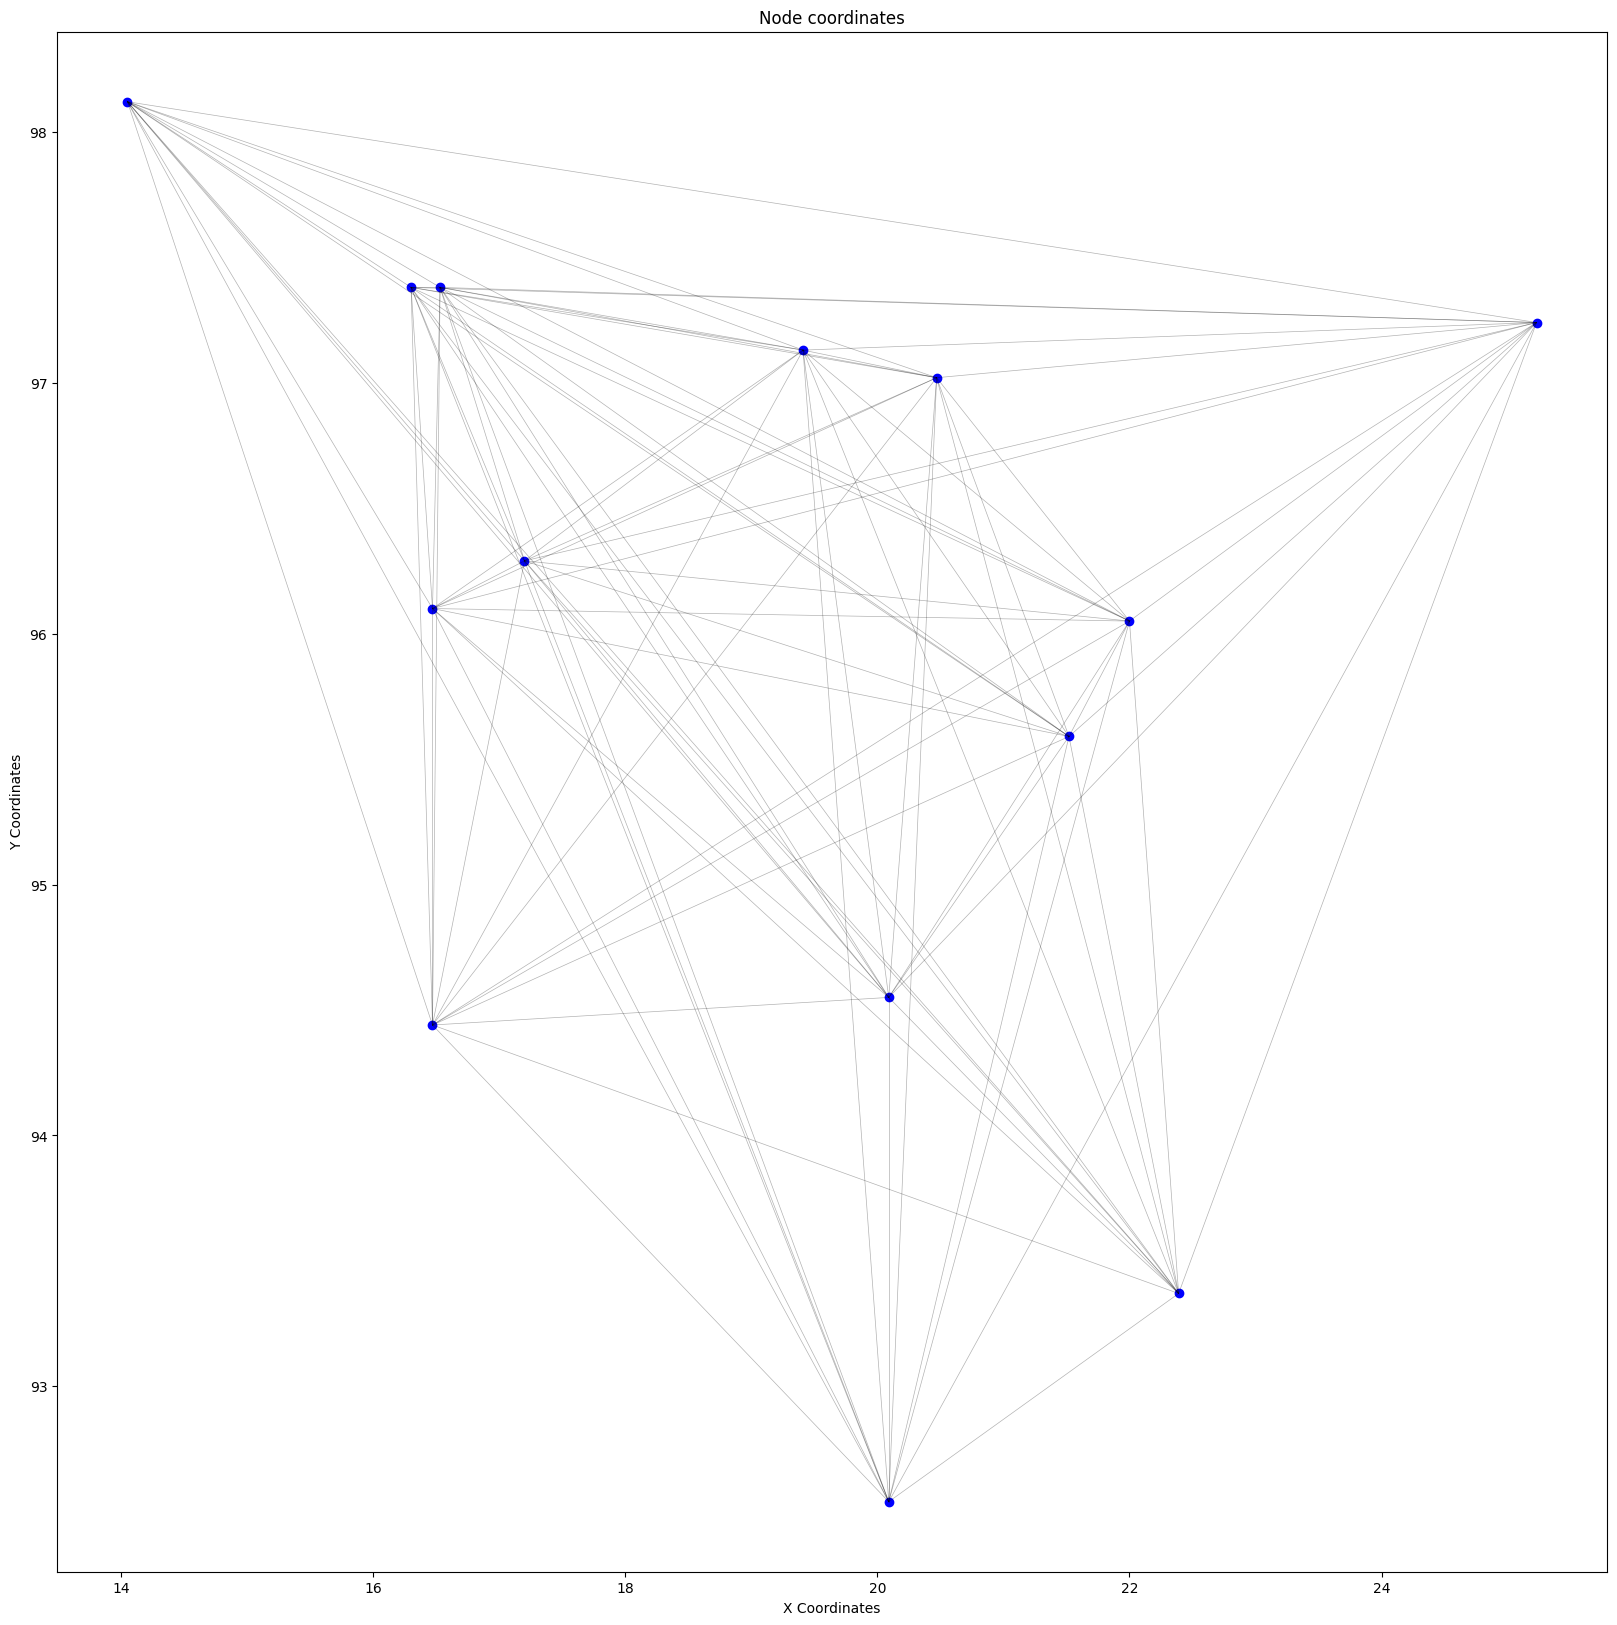

In [16]:
burma14 = TspParser(response.text)
burma14.plotCoords()

### att48

The att48 problem is a lot more complex, covering all 48 capitals of mainland USA. there is a wide distribution of nodes, with many being close together and others being separated significantly. This means that it is the perfect test for the PSO algorithms.

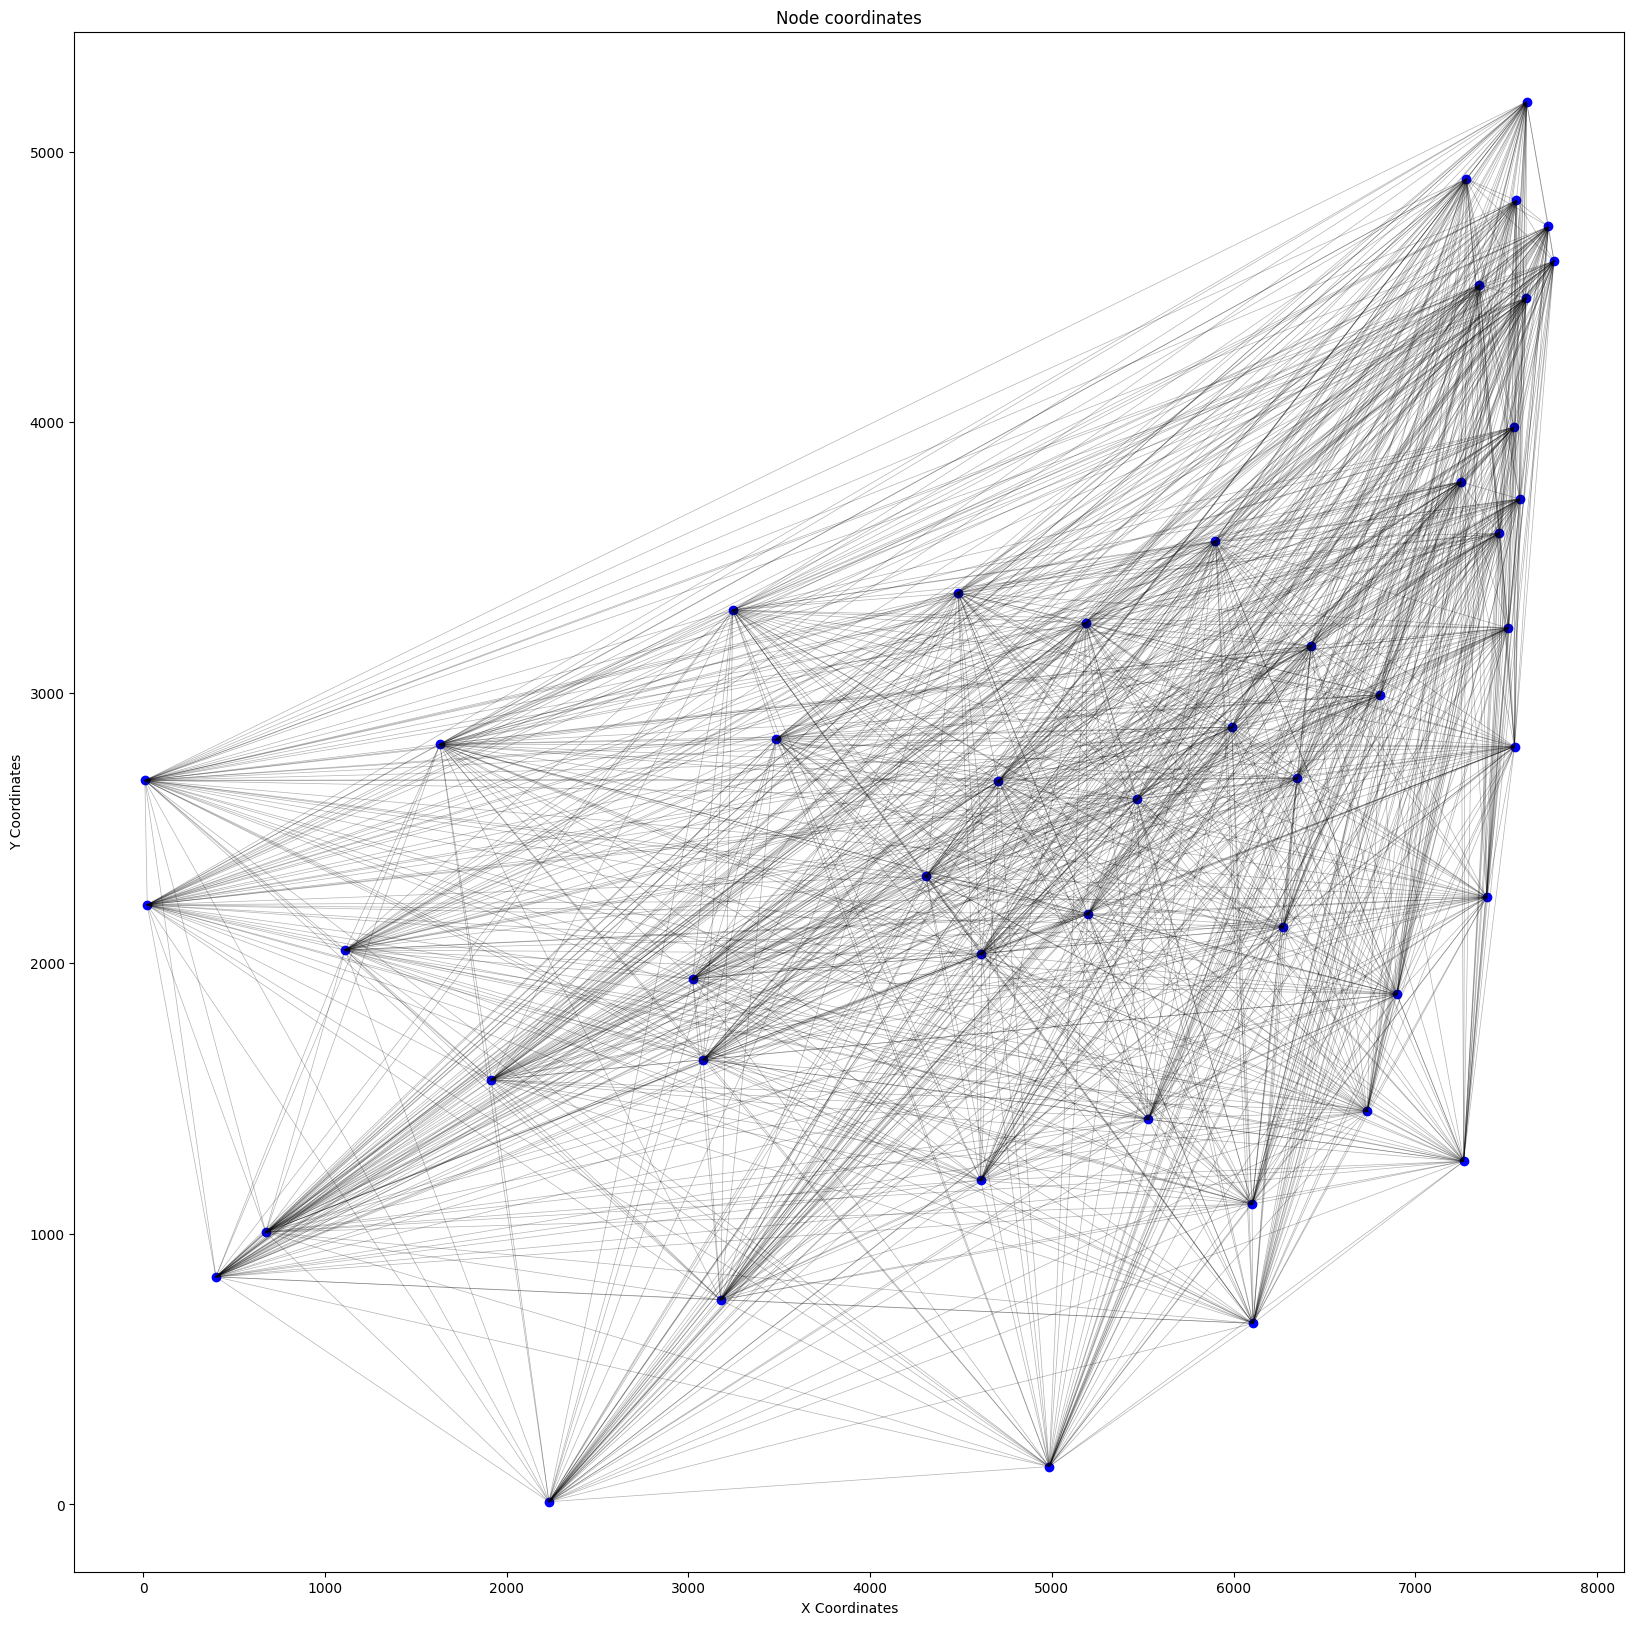

In [18]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp")
att48 = TspParser(response.text)
att48.plotCoords()

### lin105

lin105 is a significantly larger problem than the others, and is more of a stretch goal to accomplish. Hardware and time constraints mean that this problem is not feasible to solve in a timespan shorter than an hour, so I do not expect my algorithms to come to the optimal solution for this. The inclusion of this problem is more for comparison purposes.

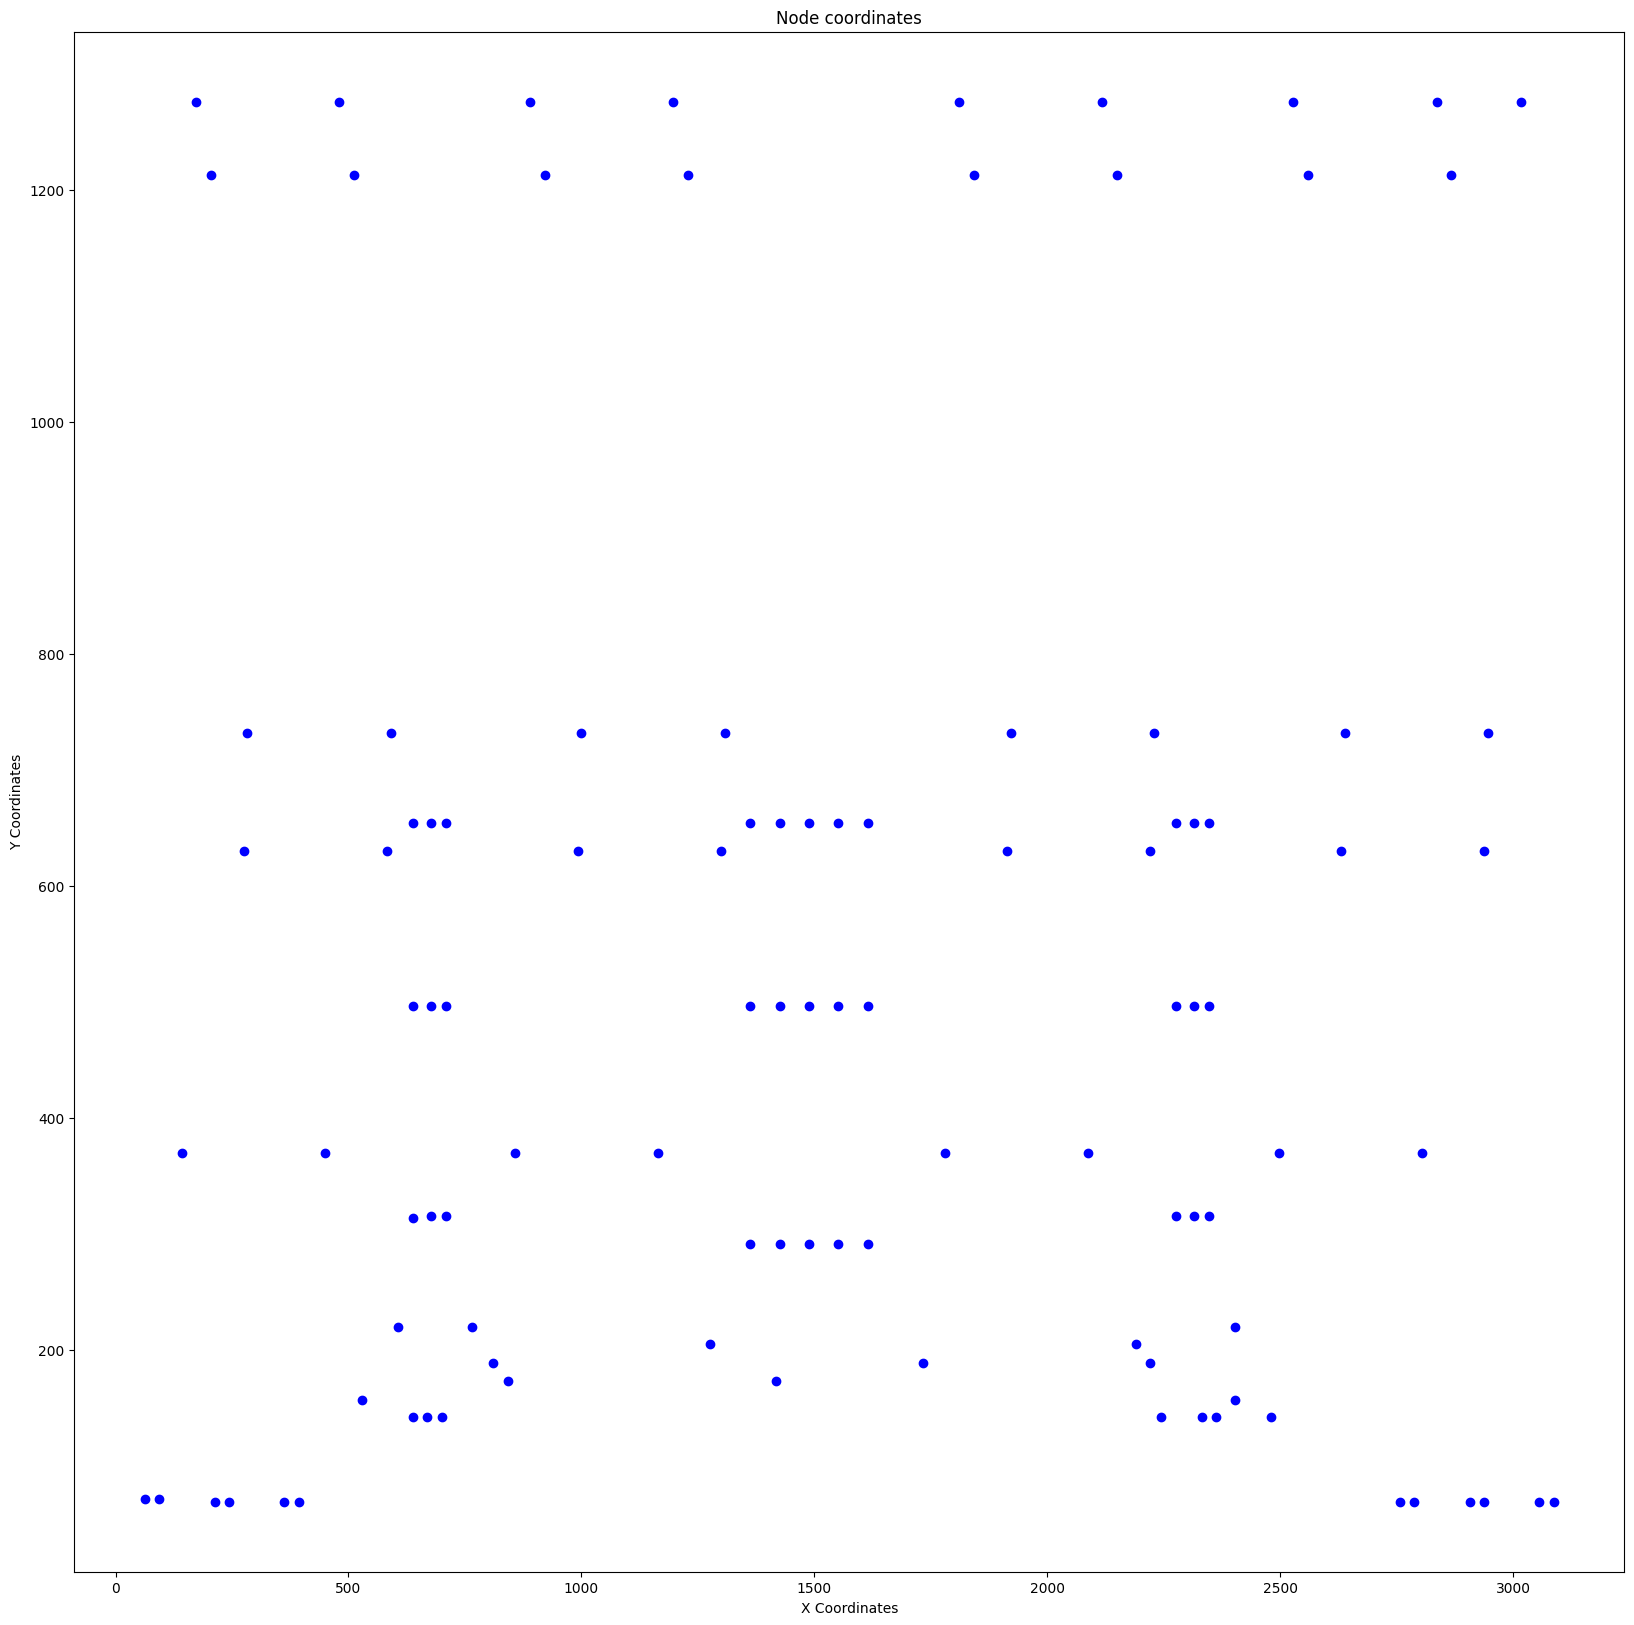

In [20]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/lin105.tsp")
lin105 = TspParser(response.text)
lin105.plotCoords(plotEdges=False)

## Comparison with Other Approaches